In [29]:
import numpy as np
import os
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import torch
from src.graph_func import graph_construction, combine_graph_dict
from src.utils_func import mk_dir, adata_preprocess, load_visium_sge
from src.SEDR_train import SEDR_Train

In [30]:
seed = 0
torch.cuda.cudnn_enabled = False
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Using device: ' + device)

Using device: cpu


## Defining some useful classes and functions

In [31]:
class Params:
    def __init__(self, k=10, knn_distanceType='euclidean', epochs=200, cell_feat_dim=200,
                feat_hidden1=100, feat_hidden2=20, gcn_hidden1=32, gcn_hidden2=8, 
                p_drop=0.2, using_dec=True, using_mask=False, feat_w=10, gcn_w=0.1, 
                dec_kl_w=10, gcn_lr=0.01, gcn_decay=0.01, dec_cluster_n=10, 
                dec_interval=20, dec_tol=0, eval_resolution=1, eval_graph_n=20,
                device='cpu'):
        self.k = k  # parameter k in spatial graph
        self.knn_distanceType = knn_distanceType  # graph distance type: euclidean/cosine/correlation
        self.epochs = epochs
        self.cell_feat_dim = cell_feat_dim  # Dim of PCA
        self.feat_hidden1 = feat_hidden1  # Dim of DNN hidden 1-layer
        self.feat_hidden2 = feat_hidden2  # Dim of DNN hidden 2-layer (Zf embedding)
        self.gcn_hidden1 = gcn_hidden1  # Dim of GCN hidden 1-layer
        self.gcn_hidden2 = gcn_hidden2  # Dim of GCN hidden 2-layer (Zg embedding)
        self.p_drop = p_drop  # dropout rate
        self.using_dec = using_dec  # DEC loss
        self.using_mask = using_mask  # mask for multi-dataset
        self.feat_w = feat_w  # Weight of DNN loss
        self.gcn_w = gcn_w  # Weight of GCN loss
        self.dec_kl_w = dec_kl_w  # Weight of DEC loss
        self.gcn_lr = gcn_lr  # Initial GCN learning rate
        self.gcn_decay = gcn_decay  # Initial GCN decay rate
        self.dec_cluster_n = dec_cluster_n  # DEC cluster number
        self.dec_interval = dec_interval  # DEC interval number
        self.dec_tol = dec_tol  # DEC tol
        self.eval_resolution = eval_resolution  # Eval cluster number
        self.eval_graph_n = 20  # Number of neighbors in kNN, used for Leiden clustering
        self.device = device
        self.save_path = None
        self.cell_num = None

In [32]:
def dataframe_to_anndata(data, spot_dist=200, spot_diameter=100):
    data_h5 = anndata.AnnData(data.values.T)
    names = data.columns
    x = [int(coords.split('x')[1]) for coords in names]
    y = [int(coords.split('x')[0]) for coords in names]
    data_h5.obs['array_col'] = x
    data_h5.obs['array_row'] = y
    data_h5.obsm['spatial'] = np.array([x, y]).T * spot_dist
    data_h5.uns['spatial'] = {data_name:{'scalefactors':{'spot_diameter_fullres':spot_diameter}}}
    return data_h5

In [33]:
def to_matrix(values, coordinates, fill=-1):
    xs, ys = [], []
    for coords in coordinates:
        y, x = coords.split('x')
        x, y = int(x), int(y)
        xs.append(x)
        ys.append(y)
    values = values.astype(float)
    color_span = np.max(values) - np.min(values)
    M = np.zeros((max(xs)+3, max(ys)+3)) + fill
    for i, val in enumerate(values):
        M[xs[i], ys[i]] = val
    return M

# Running SEDR on one section

In [34]:
data_name = '1_2'
save_fold = os.path.join('output/prostate', data_name)
data_file = '../data/prostate-twelve/P1.2.tsv'

In [37]:
data = pd.read_csv(data_file, sep='\t')
print('shape: ', data.shape)
data = data.loc[:, (data>0).sum()>=200]  # spots with at least 200 genes found
data = data[(data>0).sum(axis=1)>=2]  # genes present in at least 2 spots
print('shape after filtering:', data.shape)

shape:  (17678, 406)
shape after filtering: (15108, 406)


In [76]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

params = Params(device=device)
params.epochs = 200
params.feat_w = 2
params.eval_resolution = 0.7
adata_h5 = dataframe_to_anndata(data)
adata_h5.var_names_make_unique()
adata_X = adata_preprocess(adata_h5, min_cells=2, pca_n_comps=params.cell_feat_dim)
print('==== Preprocessing finished')
graph_dict = graph_construction(adata_h5.obsm['spatial'], adata_h5.shape[0], params)
print('==== Graph Construction finished')
params.cell_num = adata_h5.shape[0]
params.save_path = mk_dir(save_fold)

sedr_net = SEDR_Train(adata_X, graph_dict, params)
if params.using_dec:
    losses = sedr_net.train_with_dec(return_loss=True)
else:
    losses = sedr_net.train_without_dec(return_loss=True)
sedr_feat, _, _, _ = sedr_net.process()
print('==== Training finished')

===== Preprocessing Data 


/home/basia/Documents/magisterka/CBS/project/SEDR/src/graph_func.py:74: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_org = nx.adjacency_matrix(nx.from_dict_of_lists(graphdict))
GNN model train without DEC:  |                | 1 / 200 | Left time: 0.26 mins| Loss: 98.1097

==== Preprocessing finished
==== Graph Construction finished


GNN model train without DEC:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 87.1430GNN model train without DEC:  |##########      | 133 / 200 | Left time: 0.04 mins| Loss: 88.3378
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
Training Graph Net with DEC loss:  |################| 200 / 200 | Loss:

==== Training finished


In [78]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

params = Params(device=device)
params.feat_w = 2
params.eval_resolution = 0.7
adata_h5 = dataframe_to_anndata(data)
adata_h5.var_names_make_unique()
adata_X = adata_preprocess(adata_h5, min_cells=2, pca_n_comps=params.cell_feat_dim)
print('==== Preprocessing finished')
graph_dict = graph_construction(adata_h5.obsm['spatial'], adata_h5.shape[0], params)
print('==== Graph Construction finished')
params.cell_num = adata_h5.shape[0]
params.save_path = mk_dir(save_fold)

sedr_net = SEDR_Train(adata_X, graph_dict, params)
if params.using_dec:
    losses = sedr_net.train_with_dec(return_loss=True)
else:
    losses = sedr_net.train_without_dec(return_loss=True)
sedr_feat, _, _, _ = sedr_net.process()
print('==== Training finished')

===== Preprocessing Data 


/home/basia/Documents/magisterka/CBS/project/SEDR/src/graph_func.py:74: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_org = nx.adjacency_matrix(nx.from_dict_of_lists(graphdict))
GNN model train without DEC:  |                | 2 / 200 | Left time: 0.32 mins| Loss: 96.4577

==== Preprocessing finished
==== Graph Construction finished


GNN model train without DEC:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 87.1430N model train without DEC:  |                | 7 / 200 | Left time: 0.12 mins| Loss: 93.7701GNN model train without DEC:  |############### | 189 / 200 | Left time: 0.01 mins| Loss: 87.4060
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major relea

==== Training finished


## Downstream analysis using the learned latent representation
 * Clustering spots 

Found 4 clusters


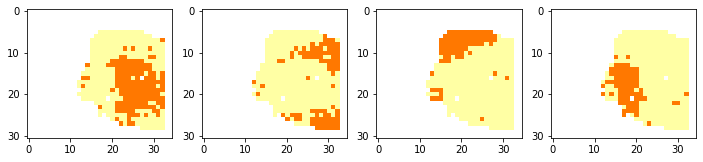

In [79]:
# data with the latent representation
adata_sedr = anndata.AnnData(sedr_feat)
adata_sedr.uns['spatial'] = adata_h5.uns['spatial']
adata_sedr.obsm['spatial'] = adata_h5.obsm['spatial']

# clustering
sc.pp.neighbors(adata_sedr, n_neighbors=params.eval_graph_n)
sc.tl.leiden(adata_sedr, key_added="SEDR_leiden", resolution=params.eval_resolution)

clustering = to_matrix(adata_sedr.obs['SEDR_leiden'], data.columns)
n_clusters = np.max(clustering) + 1
print(f'Found {int(n_clusters)} clusters')
nrows = int(np.ceil(n_clusters / 4))
fig, axes = plt.subplots(nrows, 4, figsize=(12, 6)) 
for i, ax in enumerate(axes.ravel()):
    cluster = clustering.copy()
    cluster[cluster==i] = 1.2
    cluster[(-1 < cluster) & (cluster != 1.2)] = 0
    ax.imshow(cluster, vmin=-0.3, vmax=3, cmap='hot_r')
plt.show()

## Comparing the results to Poisson model results (activity maps)

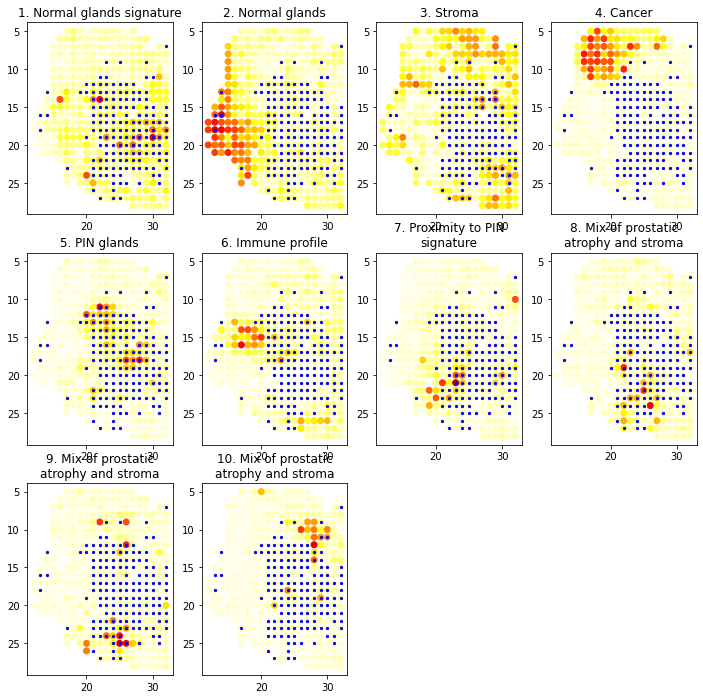

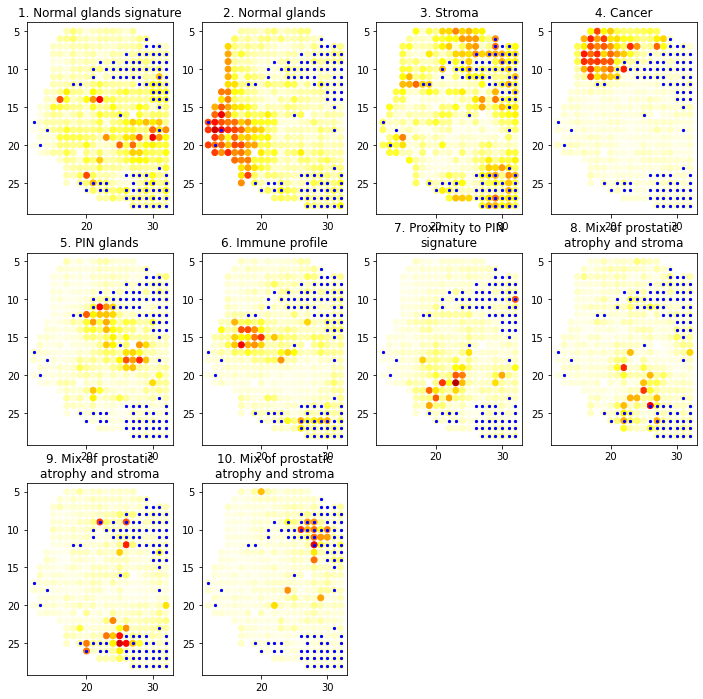

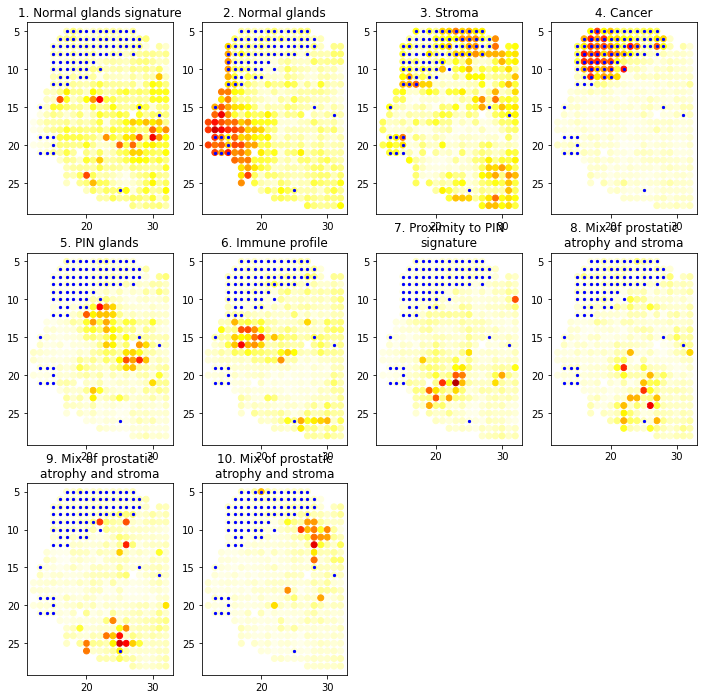

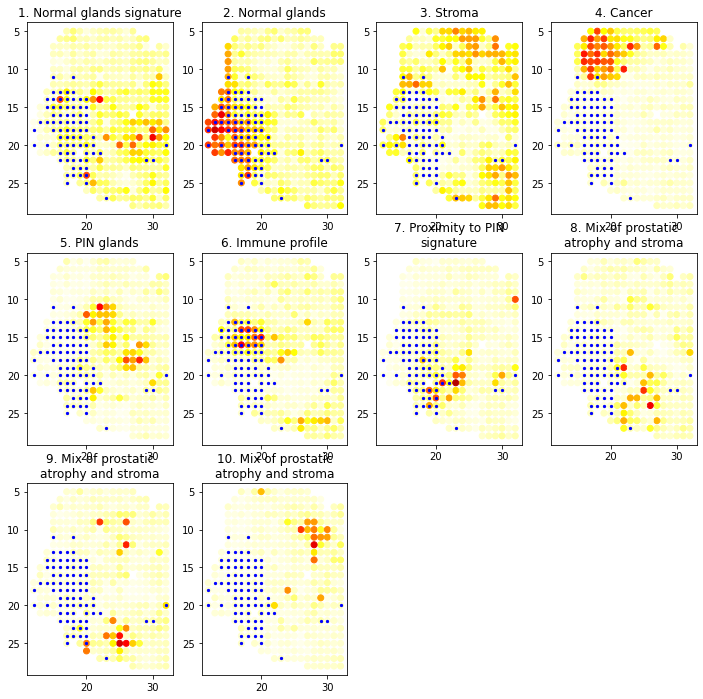

In [80]:
# First: comparing each cluster with each factor

# Poisson results
poisson_preds = pd.read_csv('../Poisson/Supplementary Dataset 1/experiment0000-contributions_spot_type.tsv', sep='\t', index_col=0)
preds_frac = np.array(poisson_preds) / np.array(poisson_preds.sum(axis=1)).reshape(-1, 1)
names = ['Normal glands signature', 'Normal glands', 'Stroma', 'Cancer', 
         'PIN glands', 'Immune profile', 'Proximity to PIN\nsignature',
         'Mix of prostatic\natrophy and stroma', 'Mix of prostatic\natrophy and stroma',
         'Mix of prostatic\natrophy and stroma']

xs = poisson_preds.index.str.split('x').str[0]
xs = xs.astype(int)
ys = poisson_preds.index.str.split('x').str[1]
ys = ys.astype(int)


# SEDR results
sedr_clusters = adata_sedr.obs['SEDR_leiden']
sedr_clusters.index = data.columns
for selected_cluster in range(4):
    cluster = sedr_clusters[np.array(sedr_clusters==str(selected_cluster))]
    coords = cluster.index

    xs_s = coords.str.split('x').str[0]
    xs_s = xs_s.astype(int)
    ys_s = coords.str.split('x').str[1]
    ys_s = ys_s.astype(int)


    fig, axes = plt.subplots(3, 4, figsize=(12, 12)) 
    for i, ax in enumerate(axes.ravel()):
        if i >= 10:
            ax.remove()
            continue
        ax.scatter(x=xs, y=ys, c=preds_frac[:, i],
                  vmin=0, vmax=1, cmap='hot_r')
        ax.scatter(x=xs_s, y=ys_s, c='b', s=5)
        ax.set_title(str(i+1) + '. ' + names[i])
        ax.invert_yaxis()
    plt.show()

SEDR cluster: 0
Poisson factors: ['Normal glands signature', 'PIN glands', 'Mix of prostatic atrophy and stroma', 'Mix of prostatic atrophy and stroma']

SEDR cluster: 1
Poisson factors: ['Stroma', 'Mix of prostatic atrophy and stroma']

SEDR cluster: 2
Poisson factors: ['Cancer']

SEDR cluster: 3
Poisson factors: ['Normal glands']



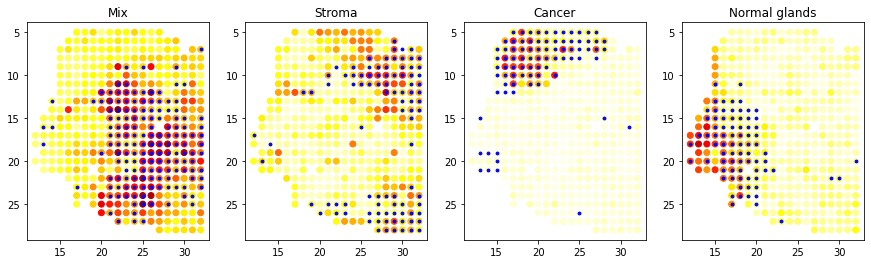

In [81]:
# Poisson results
poisson_preds = pd.read_csv('../Poisson/Supplementary Dataset 1/experiment0000-contributions_spot_type.tsv', sep='\t', index_col=0)
preds_frac = np.array(poisson_preds) / np.array(poisson_preds.sum(axis=1)).reshape(-1, 1)
names_orig = ['Normal glands signature', 'Normal glands', 'Stroma', 'Cancer', 
             'PIN glands', 'Immune profile', 'Proximity to PIN\nsignature',
             'Mix of prostatic\natrophy and stroma', 'Mix of prostatic\natrophy and stroma',
             'Mix of prostatic\natrophy and stroma']

xs = poisson_preds.index.str.split('x').str[0]
xs = xs.astype(int)
ys = poisson_preds.index.str.split('x').str[1]
ys = ys.astype(int)

# SEDR results
sedr_clusters = adata_sedr.obs['SEDR_leiden']
sedr_clusters.index = data.columns
matches = [[0, 4, 7, 8], [2, 9], [3], [1]]
names = ['Mix', 'Stroma', 'Cancer', 'Normal glands']
fig, axes = plt.subplots(1, 4, figsize=(15, 4)) 
for selected_cluster, ax in enumerate(axes.ravel()):
    cluster = sedr_clusters[np.array(sedr_clusters==str(selected_cluster))]

    coords = cluster.index
    xs_s = coords.str.split('x').str[0]
    xs_s = xs_s.astype(int)
    ys_s = coords.str.split('x').str[1]
    ys_s = ys_s.astype(int)
    
    m = np.array(matches[selected_cluster])
    ax.scatter(x=xs, y=ys, c=preds_frac[:, m].sum(axis=1),
               vmin=0, vmax=1, cmap='hot_r')
    ax.scatter(x=xs_s, y=ys_s, c='b', s=8)
    ax.set_title(selected_cluster)
    ax.invert_yaxis()
    factors = [names_orig[f].replace('\n', ' ') for f in matches[selected_cluster]]
    print(f'SEDR cluster: {selected_cluster}\nPoisson factors: {factors}\n')
    ax.set_title(names[selected_cluster])
plt.savefig('../SEDR/clusters1.2_comparison.png', bbox_inches='tight')

### Running the model for different number of epochs
* the results look similar
* the more epochs, the more "dense" the clusters are
    * probably trained more in the "spatial" direction (VGAE) instead of transcriptomic (autoencoder)

===== Preprocessing Data 
==== Preprocessing finished


/home/basia/Documents/magisterka/CBS/project/SEDR/src/graph_func.py:74: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_org = nx.adjacency_matrix(nx.from_dict_of_lists(graphdict))
GNN model train without DEC:  |                | 1 / 100 | Left time: 0.13 mins| Loss: 98.1097

==== Graph Construction finished


GNN model train without DEC:  |################| 100 / 100 | Left time: 0.00 mins| Loss: 89.1684
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
Training Graph Net with DEC loss:  |################| 100 / 100 | Loss: 87.2253


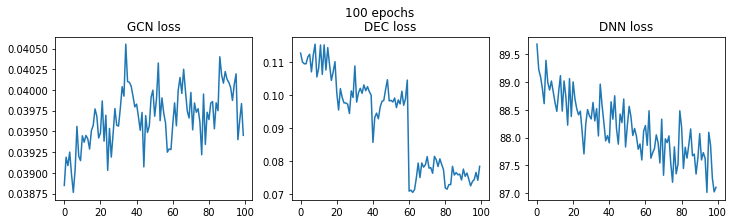

==== Training finished
Found 5 clusters


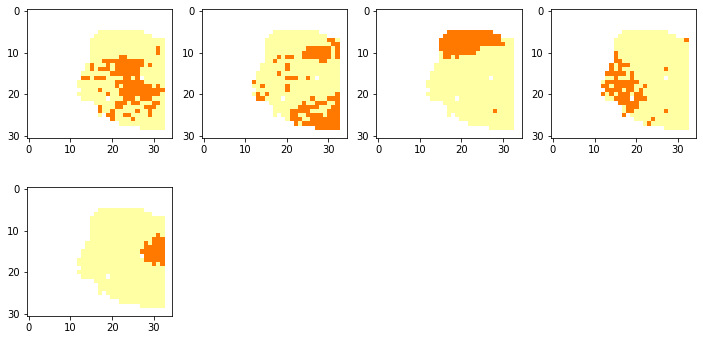

GNN model train without DEC:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 87.1430N model train without DEC:  |                | 7 / 200 | Left time: 0.16 mins| Loss: 93.7701GNN model train without DEC:  |####            | 52 / 200 | Left time: 0.13 mins| Loss: 90.7431GNN model train without DEC:  |############    | 154 / 200 | Left time: 0.06 mins| Loss: 88.0902
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div m

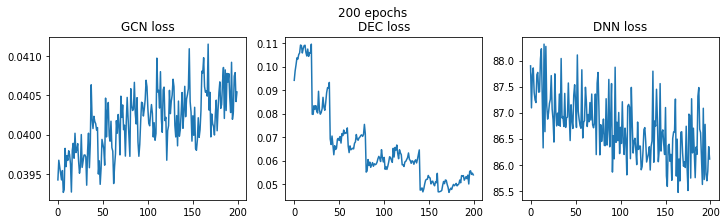

==== Training finished
Found 4 clusters


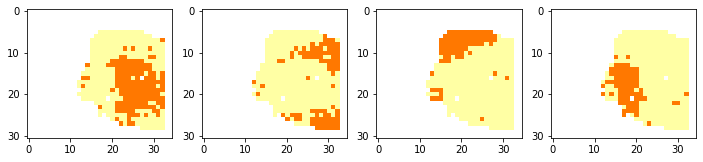

GNN model train without DEC:  |################| 300 / 300 | Left time: 0.00 mins| Loss: 86.2719NN model train without DEC:  |####            | 88 / 300 | Left time: 0.13 mins| Loss: 89.5855GNN model train without DEC:  |#####           | 96 / 300 | Left time: 0.12 mins| Loss: 89.4843GNN model train without DEC:  |#######         | 137 / 300 | Left time: 0.09 mins| Loss: 88.6263GNN model train without DEC:  |#######         | 149 / 300 | Left time: 0.11 mins| Loss: 88.7338
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch 

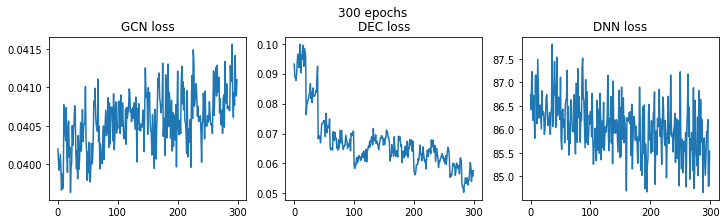

==== Training finished
Found 6 clusters


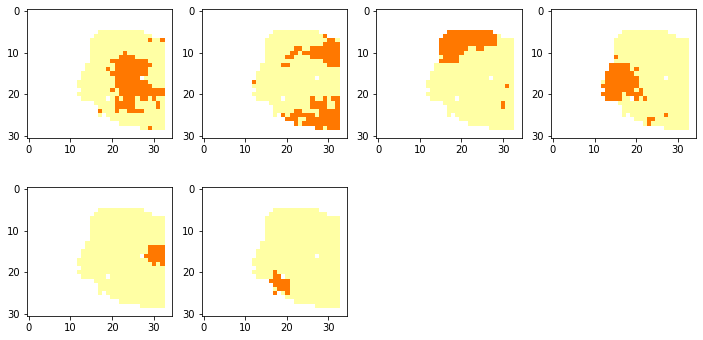

In [89]:
params = Params(device=device)
adata_h5 = dataframe_to_anndata(data)
adata_h5.var_names_make_unique()
adata_X = adata_preprocess(adata_h5, min_cells=2, pca_n_comps=params.cell_feat_dim)
print('==== Preprocessing finished')
graph_dict = graph_construction(adata_h5.obsm['spatial'], adata_h5.shape[0], params)
print('==== Graph Construction finished')
params.cell_num = adata_h5.shape[0]
params.save_path = mk_dir(save_fold)

for epochs in [100, 200, 300]:
    params.epochs = epochs
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    params.feat_w = 2
    params.eval_resolution = 0.7

    sedr_net = SEDR_Train(adata_X, graph_dict, params)
    if params.using_dec:
        losses = sedr_net.train_with_dec(return_loss=True)
    else:
        losses = sedr_net.train_without_dec(return_loss=True)
    fig, axes = plt.subplots(1, 3, figsize=(12, 3)) 
    loss_names = ['GCN loss', 'DEC loss', 'DNN loss']
    for i, ax in enumerate(axes.ravel()):
        ax.plot(losses[i])
        ax.set_title(loss_names[i])
    plt.suptitle(f'{epochs} epochs', y=1.02)
    plt.show()
    sedr_feat, _, _, _ = sedr_net.process()
    print('==== Training finished')

    # data with the latent representation
    adata_sedr = anndata.AnnData(sedr_feat)
    adata_sedr.uns['spatial'] = adata_h5.uns['spatial']
    adata_sedr.obsm['spatial'] = adata_h5.obsm['spatial']

    # clustering
    sc.pp.neighbors(adata_sedr, n_neighbors=params.eval_graph_n)
    sc.tl.leiden(adata_sedr, key_added="SEDR_leiden", resolution=params.eval_resolution)

    clustering = to_matrix(adata_sedr.obs['SEDR_leiden'], data.columns)
    n_clusters = np.max(clustering) + 1
    print(f'Found {int(n_clusters)} clusters')
    nrows = int(np.ceil(n_clusters / 4))
    fig, axes = plt.subplots(nrows, 4, figsize=(12, 3*nrows)) 
    for i, ax in enumerate(axes.ravel()):
        cluster = clustering.copy()
        if np.sum(cluster==i) == 0:
            ax.remove()
            continue
        cluster[cluster==i] = 1.2
        cluster[(-1 < cluster) & (cluster != 1.2)] = 0
        ax.imshow(cluster, vmin=-0.3, vmax=3, cmap='hot_r')
    plt.show()

### Running the model with different weights of the autoencoder (transcriptomic latent representation)
* the results look similar, except for the first case (feat_w=1)
* the higher the weight, the more "dense" the clusters are
    * counterintuitive
    * probably just because with a higher weight, gradient is higher so the model trains faster

===== Preprocessing Data 
==== Preprocessing finished
==== Graph Construction finished


/home/basia/Documents/magisterka/CBS/project/SEDR/src/graph_func.py:74: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_org = nx.adjacency_matrix(nx.from_dict_of_lists(graphdict))
GNN model train without DEC:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 44.7014
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to be

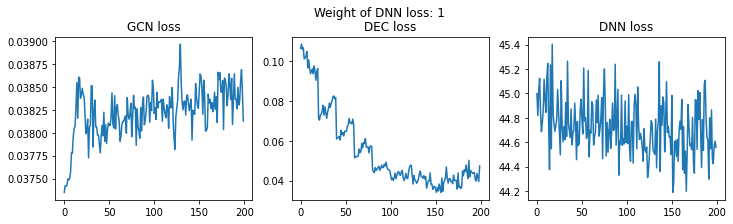

==== Training finished
Found 6 clusters


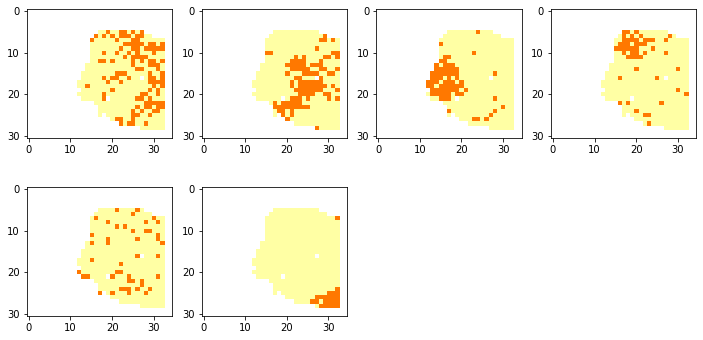

GNN model train without DEC:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 212.5134GNN model train without DEC:  |############    | 150 / 200 | Left time: 0.05 mins| Loss: 215.2368
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
Training Graph Net with DEC loss:  |################| 200 / 200 | Los

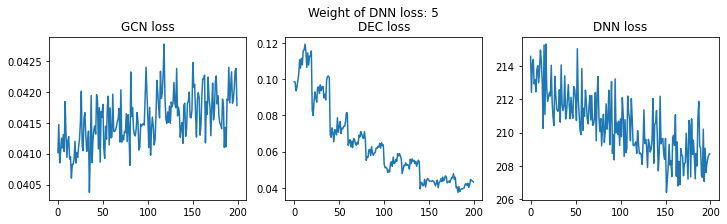

==== Training finished
Found 6 clusters


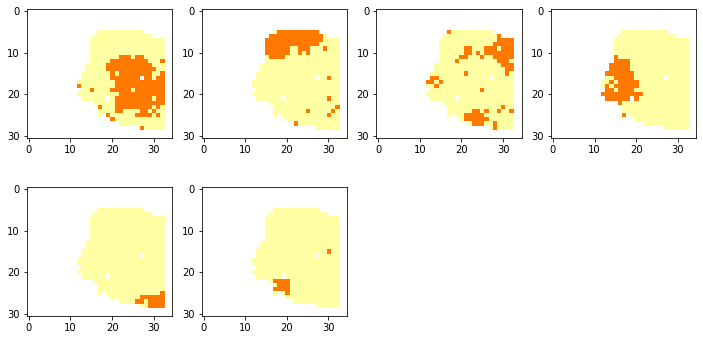

GNN model train without DEC:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 839.0370
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
Training Graph Net with DEC loss:  |################| 200 / 200 | Loss: 812.2507


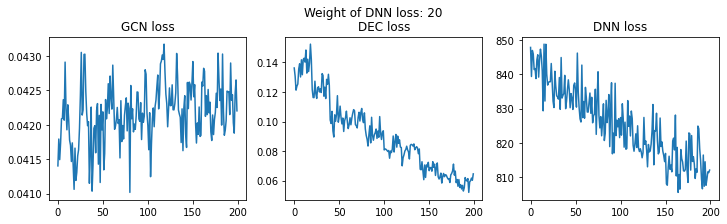

==== Training finished
Found 6 clusters


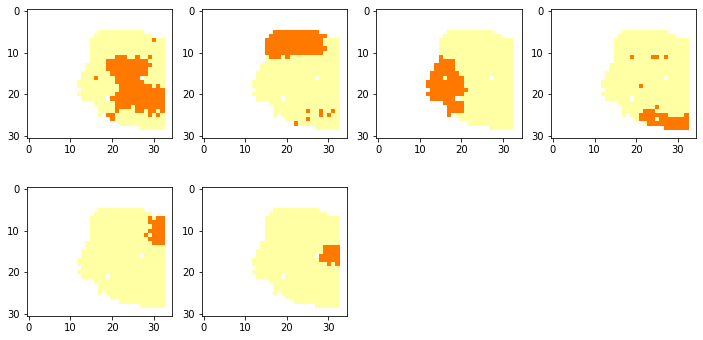

GNN model train without DEC:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 2093.5203NN model train without DEC:  |######          | 76 / 200 | Left time: 0.10 mins| Loss: 2202.0044GNN model train without DEC:  |#######         | 89 / 200 | Left time: 0.04 mins| Loss: 2193.4851
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next majo

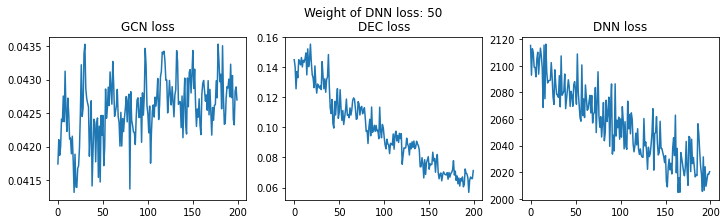

==== Training finished
Found 6 clusters


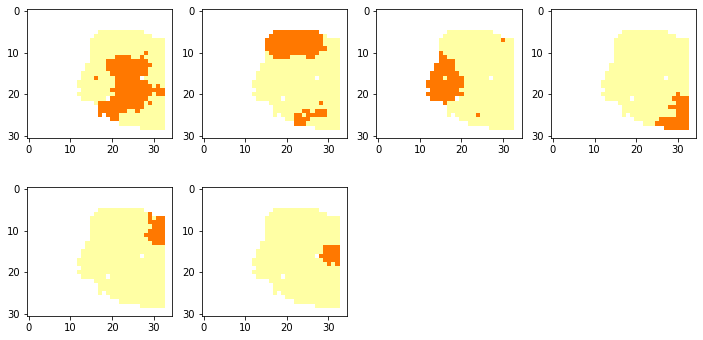

In [90]:
params = Params(device=device)
adata_h5 = dataframe_to_anndata(data)
adata_h5.var_names_make_unique()
adata_X = adata_preprocess(adata_h5, min_cells=2, pca_n_comps=params.cell_feat_dim)
print('==== Preprocessing finished')
graph_dict = graph_construction(adata_h5.obsm['spatial'], adata_h5.shape[0], params)
print('==== Graph Construction finished')
params.cell_num = adata_h5.shape[0]
params.save_path = mk_dir(save_fold)

for feat_w in [1, 5, 20, 50]:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    params.feat_w = feat_w
    params.eval_resolution = 0.7

    sedr_net = SEDR_Train(adata_X, graph_dict, params)
    if params.using_dec:
        losses = sedr_net.train_with_dec(return_loss=True)
    else:
        losses = sedr_net.train_without_dec(return_loss=True)
    fig, axes = plt.subplots(1, 3, figsize=(12, 3)) 
    for i, ax in enumerate(axes.ravel()):
        ax.plot(losses[i])
        ax.set_title(loss_names[i])
    plt.suptitle(f'Weight of DNN loss: {feat_w}', y=1.02)
    plt.show()
    sedr_feat, _, _, _ = sedr_net.process()
    print('==== Training finished')

    # data with the latent representation
    adata_sedr = anndata.AnnData(sedr_feat)
    adata_sedr.uns['spatial'] = adata_h5.uns['spatial']
    adata_sedr.obsm['spatial'] = adata_h5.obsm['spatial']

    # clustering
    sc.pp.neighbors(adata_sedr, n_neighbors=params.eval_graph_n)
    sc.tl.leiden(adata_sedr, key_added="SEDR_leiden", resolution=params.eval_resolution)

    clustering = to_matrix(adata_sedr.obs['SEDR_leiden'], data.columns)
    n_clusters = np.max(clustering) + 1
    print(f'Found {int(n_clusters)} clusters')
    nrows = int(np.ceil(n_clusters / 4))
    fig, axes = plt.subplots(nrows, 4, figsize=(12, 3*nrows)) 
    for i, ax in enumerate(axes.ravel()):
        cluster = clustering.copy()
        if np.sum(cluster==i) == 0:
            ax.remove()
            continue
        cluster[cluster==i] = 1.2
        cluster[(-1 < cluster) & (cluster != 1.2)] = 0
        ax.imshow(cluster, vmin=-0.3, vmax=3, cmap='hot_r')
    plt.show()

### Running the model with different weights of the VGAE (spatial latent representation)
* different clustering but hard to draw any conclusions

===== Preprocessing Data 
==== Preprocessing finished
==== Graph Construction finished


/home/basia/Documents/magisterka/CBS/project/SEDR/src/graph_func.py:74: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_org = nx.adjacency_matrix(nx.from_dict_of_lists(graphdict))
GNN model train without DEC:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 87.1120NN model train without DEC:  |##              | 26 / 200 | Left time: 0.10 mins| Loss: 92.0094
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides o

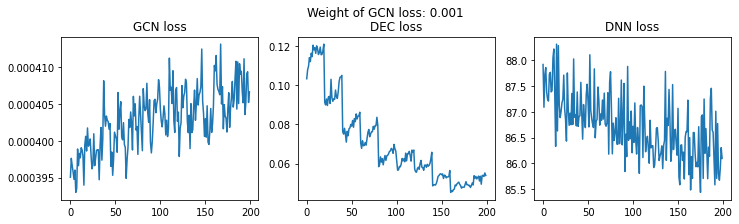

==== Training finished
Found 4 clusters


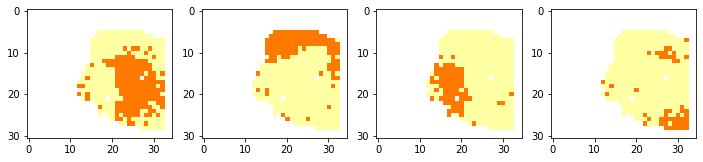

GNN model train without DEC:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 90.8782
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
Training Graph Net with DEC loss:  |################| 200 / 200 | Loss: 90.3479


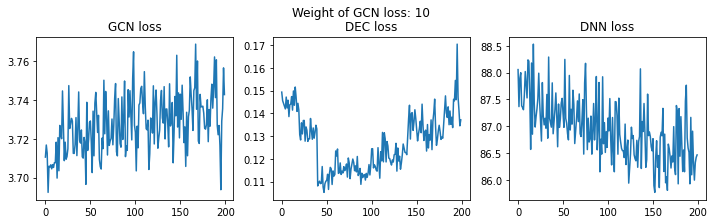

==== Training finished
Found 6 clusters


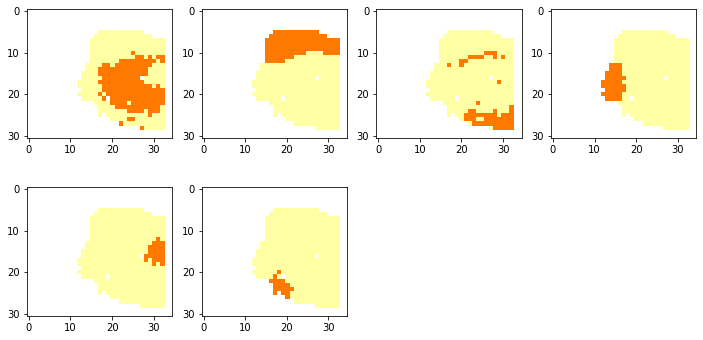

GNN model train without DEC:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 105.4714
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
Training Graph Net with DEC loss:  |################| 200 / 200 | Loss: 104.8249


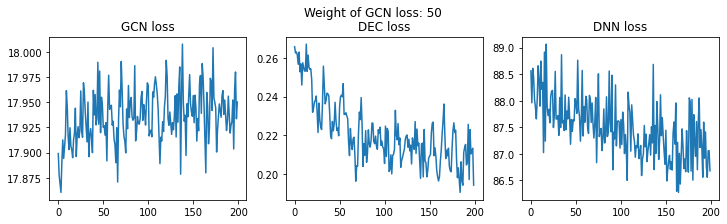

==== Training finished
Found 6 clusters


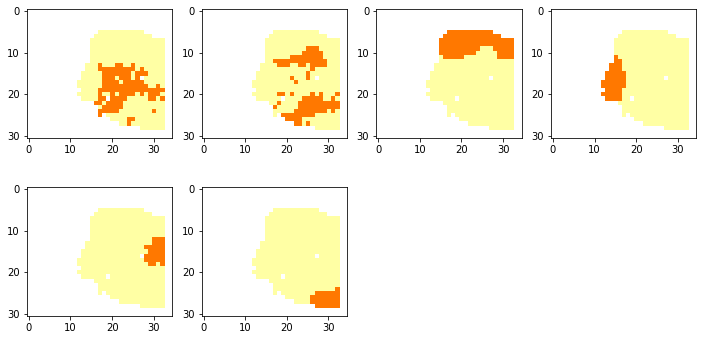

GNN model train without DEC:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 158.7462GNN model train without DEC:  |#############   | 164 / 200 | Left time: 0.02 mins| Loss: 159.7951GNN model train without DEC:  |#############   | 169 / 200 | Left time: 0.02 mins| Loss: 159.2551
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next majo

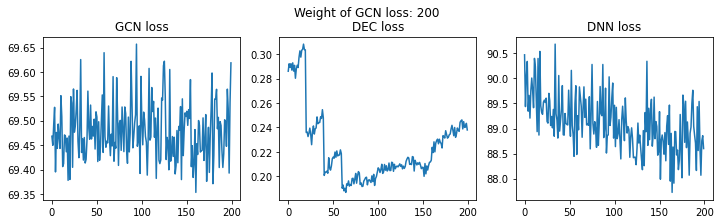

==== Training finished
Found 4 clusters


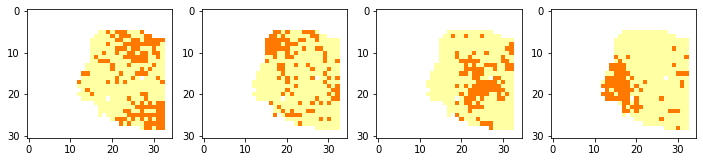

In [93]:
params = Params(device=device)
adata_h5 = dataframe_to_anndata(data)
adata_h5.var_names_make_unique()
adata_X = adata_preprocess(adata_h5, min_cells=2, pca_n_comps=params.cell_feat_dim)
print('==== Preprocessing finished')
graph_dict = graph_construction(adata_h5.obsm['spatial'], adata_h5.shape[0], params)
print('==== Graph Construction finished')
params.cell_num = adata_h5.shape[0]
params.save_path = mk_dir(save_fold)

for gcn_w in [0.001, 10, 50, 200]:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    params.gcn_w = gcn_w
    params.feat_w = 2
    params.eval_resolution = 0.7

    sedr_net = SEDR_Train(adata_X, graph_dict, params)
    if params.using_dec:
        losses = sedr_net.train_with_dec(return_loss=True)
    else:
        losses = sedr_net.train_without_dec(return_loss=True)
    fig, axes = plt.subplots(1, 3, figsize=(12, 3)) 
    for i, ax in enumerate(axes.ravel()):
        ax.plot(losses[i])
        ax.set_title(loss_names[i])
    plt.suptitle(f'Weight of GCN loss: {gcn_w}', y=1.02)
    plt.show()
    sedr_feat, _, _, _ = sedr_net.process()
    print('==== Training finished')

    # data with the latent representation
    adata_sedr = anndata.AnnData(sedr_feat)
    adata_sedr.uns['spatial'] = adata_h5.uns['spatial']
    adata_sedr.obsm['spatial'] = adata_h5.obsm['spatial']

    # clustering
    sc.pp.neighbors(adata_sedr, n_neighbors=params.eval_graph_n)
    sc.tl.leiden(adata_sedr, key_added="SEDR_leiden", resolution=params.eval_resolution)

    clustering = to_matrix(adata_sedr.obs['SEDR_leiden'], data.columns)
    n_clusters = np.max(clustering) + 1
    print(f'Found {int(n_clusters)} clusters')
    nrows = int(np.ceil(n_clusters / 4))
    fig, axes = plt.subplots(nrows, 4, figsize=(12, 3*nrows)) 
    for i, ax in enumerate(axes.ravel()):
        cluster = clustering.copy()
        if np.sum(cluster==i) == 0:
            ax.remove()
            continue
        cluster[cluster==i] = 1.2
        cluster[(-1 < cluster) & (cluster != 1.2)] = 0
        ax.imshow(cluster, vmin=-0.3, vmax=3, cmap='hot_r')
    plt.show()

### Running the model with different weights of DEC
* the higher the weight, the more dense, compact the clusters are

===== Preprocessing Data 


/home/basia/Documents/magisterka/CBS/project/SEDR/src/graph_func.py:74: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_org = nx.adjacency_matrix(nx.from_dict_of_lists(graphdict))
GNN model train without DEC:  |                | 3 / 200 | Left time: 0.08 mins| Loss: 95.4448

==== Preprocessing finished
==== Graph Construction finished


GNN model train without DEC:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 87.1430NN model train without DEC:  |######          | 75 / 200 | Left time: 0.04 mins| Loss: 90.0018GNN model train without DEC:  |############    | 152 / 200 | Left time: 0.03 mins| Loss: 88.6145GNN model train without DEC:  |##############  | 180 / 200 | Left time: 0.01 mins| Loss: 88.5298
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL di

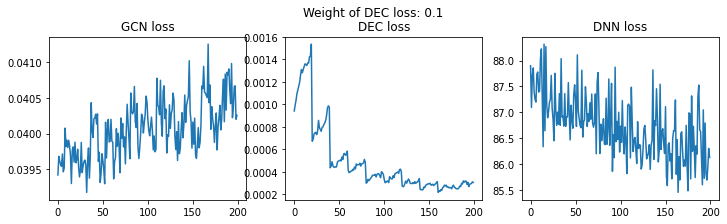

==== Training finished
Found 4 clusters


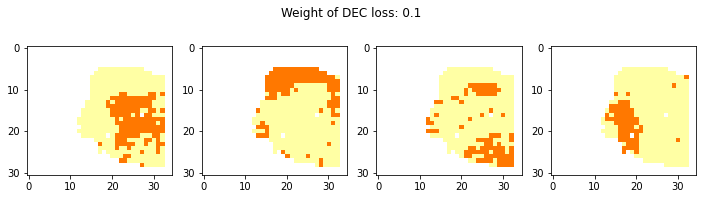

GNN model train without DEC:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 87.1430NN model train without DEC:  |#####           | 63 / 200 | Left time: 0.06 mins| Loss: 90.2341GNN model train without DEC:  |##########      | 126 / 200 | Left time: 0.04 mins| Loss: 88.1570GNN model train without DEC:  |##########      | 135 / 200 | Left time: 0.04 mins| Loss: 88.0750GNN model train without DEC:  |############    | 156 / 200 | Left time: 0.05 mins| Loss: 88.0833
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch

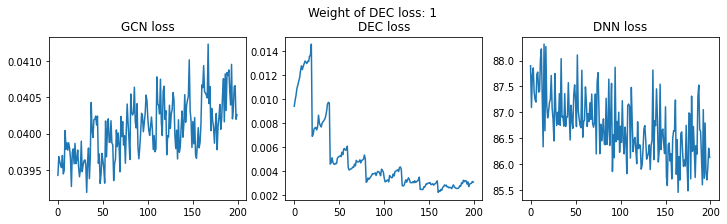

==== Training finished
Found 4 clusters


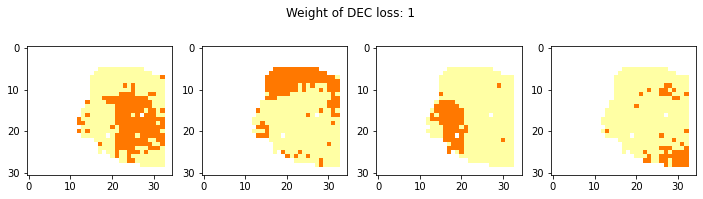

GNN model train without DEC:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 87.1430NN model train without DEC:  |#######         | 92 / 200 | Left time: 0.04 mins| Loss: 88.8366GNN model train without DEC:  |##########      | 130 / 200 | Left time: 0.03 mins| Loss: 88.4425GNN model train without DEC:  |############### | 197 / 200 | Left time: 0.00 mins| Loss: 87.9201
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL di

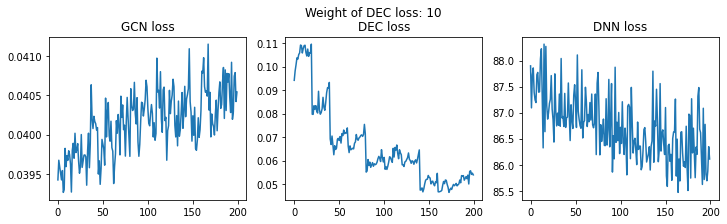

==== Training finished
Found 4 clusters


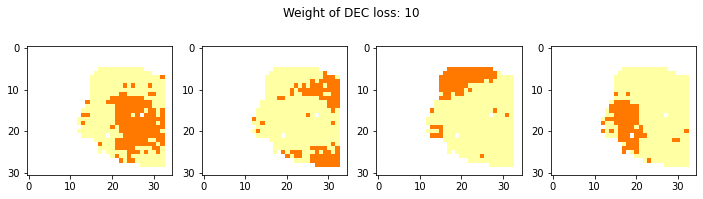

GNN model train without DEC:  |################| 200 / 200 | Left time: 0.00 mins| Loss: 87.1430NN model train without DEC:  |                | 11 / 200 | Left time: 0.08 mins| Loss: 93.1712GNN model train without DEC:  |#               | 13 / 200 | Left time: 0.08 mins| Loss: 93.0619GNN model train without DEC:  |##              | 25 / 200 | Left time: 0.06 mins| Loss: 91.9018GNN model train without DEC:  |############    | 151 / 200 | Left time: 0.02 mins| Loss: 88.2719
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch s

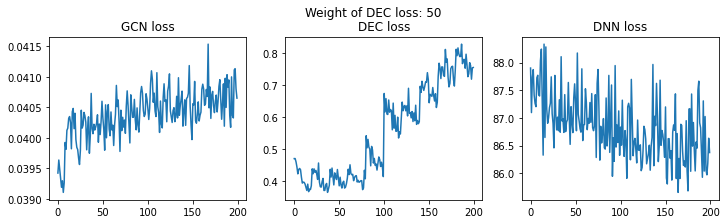

==== Training finished
Found 6 clusters


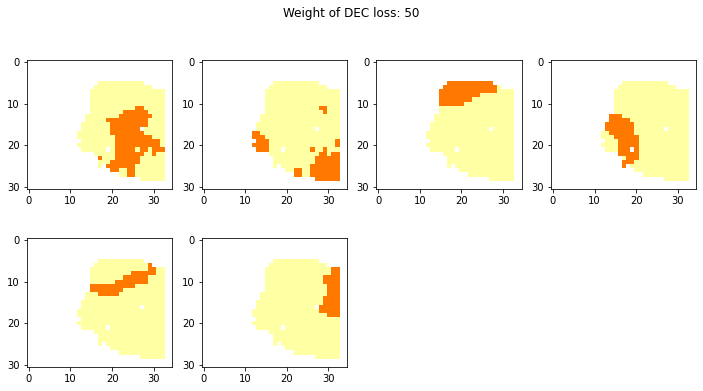

In [92]:
params = Params(device=device)
adata_h5 = dataframe_to_anndata(data)
adata_h5.var_names_make_unique()
adata_X = adata_preprocess(adata_h5, min_cells=2, pca_n_comps=params.cell_feat_dim)
print('==== Preprocessing finished')
graph_dict = graph_construction(adata_h5.obsm['spatial'], adata_h5.shape[0], params)
print('==== Graph Construction finished')
params.cell_num = adata_h5.shape[0]
params.save_path = mk_dir(save_fold)

for dec_kl_w in [0.1, 1, 10, 50]:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    params.dec_kl_w = dec_kl_w
    params.feat_w = 2
    params.eval_resolution = 0.7

    sedr_net = SEDR_Train(adata_X, graph_dict, params)
    if params.using_dec:
        losses = sedr_net.train_with_dec(return_loss=True)
    else:
        losses = sedr_net.train_without_dec(return_loss=True)
    fig, axes = plt.subplots(1, 3, figsize=(12, 3)) 
    for i, ax in enumerate(axes.ravel()):
        ax.plot(losses[i])
        ax.set_title(loss_names[i])
    plt.suptitle(f'Weight of DEC loss: {dec_kl_w}', y=1.02)
    plt.show()
    sedr_feat, _, _, _ = sedr_net.process()
    print('==== Training finished')

    # data with the latent representation
    adata_sedr = anndata.AnnData(sedr_feat)
    adata_sedr.uns['spatial'] = adata_h5.uns['spatial']
    adata_sedr.obsm['spatial'] = adata_h5.obsm['spatial']

    # clustering
    sc.pp.neighbors(adata_sedr, n_neighbors=params.eval_graph_n)
    sc.tl.leiden(adata_sedr, key_added="SEDR_leiden", resolution=params.eval_resolution)

    clustering = to_matrix(adata_sedr.obs['SEDR_leiden'], data.columns)
    n_clusters = np.max(clustering) + 1
    print(f'Found {int(n_clusters)} clusters')
    nrows = int(np.ceil(n_clusters / 4))
    fig, axes = plt.subplots(nrows, 4, figsize=(12, 3*nrows)) 
    for i, ax in enumerate(axes.ravel()):
        cluster = clustering.copy()
        if np.sum(cluster==i) == 0:
            ax.remove()
            continue
        cluster[cluster==i] = 1.2
        cluster[(-1 < cluster) & (cluster != 1.2)] = 0
        ax.imshow(cluster, vmin=-0.3, vmax=3, cmap='hot_r')
    plt.suptitle(f'Weight of DEC loss: {dec_kl_w}')
    plt.show()

# Running SEDR on three sections

In [103]:
data_name = 'all_sections'
save_fold = os.path.join('output/prostate', data_name)
sections = ['1.2', '2.4', '3.3']

In [112]:
sections = ['1.2', '2.4', '3.3']
datas = []
for section in sections:
    data_file = '../data/prostate-twelve/P' + section + '.tsv'
    data = pd.read_csv(data_file, sep='\t')
    print(section, data.shape)
    data = data.loc[:, (data>0).sum()>=200]
    data = data[(data>0).sum(axis=1)>=2]
    print('\tfiltered:', data.shape)
    datas.append(data)

1.2 (17678, 406)
	filtered: (15108, 406)
2.4 (15697, 448)
	filtered: (12883, 431)
3.3 (17335, 501)
	filtered: (13870, 495)


In [105]:
genes = set(datas[0].index)
for i in range(1, len(sections)):
    genes = genes.intersection(datas[i].index)
genes = list(genes)
print(len(genes))

12017


In [131]:
save_root = 'SEDR_result/all_sections/'
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

params = Params(device=device)
params.epochs = 300
params.feat_hidden1 = 300
params.using_mask = True
    
    
# Combining data from the sections
for proj_idx, section in enumerate(sections):
    data = datas[proj_idx]
    data = data.loc[genes]
    adata_h5_tmp = dataframe_to_anndata(data)
    adata_h5_tmp.obs['batch_label'] = [section] * adata_h5_tmp.shape[0]
    graph_dict_tmp = graph_construction(adata_h5_tmp.obsm['spatial'], adata_h5_tmp.shape[0], params)
    if proj_idx == 0:
        adata_h5 = adata_h5_tmp
        graph_dict = graph_dict_tmp
        proj_name = section
    else:
        var_names = adata_h5.var_names.intersection(adata_h5_tmp.var_names)
        adata_h5 = adata_h5[:, var_names]
        adata_h5_tmp = adata_h5_tmp[:, var_names]
        adata_h5 = adata_h5.concatenate(adata_h5_tmp)
        graph_dict = combine_graph_dict(graph_dict, graph_dict_tmp)
        proj_name = proj_name + '_' + section

print('Combined adata: (' + str(adata_h5.shape[0]) + ', ' + str(adata_h5.shape[1]) + ')')

params.cell_num = adata_h5.shape[0]
params.save_path = mk_dir(os.path.join(save_root, proj_name))

adata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=params.cell_feat_dim)
print('==== Preprocessing finished')

/home/basia/Documents/magisterka/CBS/project/SEDR/src/graph_func.py:74: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_org = nx.adjacency_matrix(nx.from_dict_of_lists(graphdict))
/home/basia/Documents/magisterka/CBS/project/SEDR/src/graph_func.py:74: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_org = nx.adjacency_matrix(nx.from_dict_of_lists(graphdict))
/home/basia/Documents/magisterka/CBS/project/SEDR/src/graph_func.py:74: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_org = nx.adjacency_matrix(nx.from_dict_of_lists(graphdict))


Combined adata: (1332, 12017)
===== Preprocessing Data 
==== Preprocessing finished


GNN model train without DEC:  |################| 300 / 300 | Left time: 0.00 mins| Loss: 181.8639
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
Training Graph Net with DEC loss:  |################| 300 / 300 | Loss: 182.1889


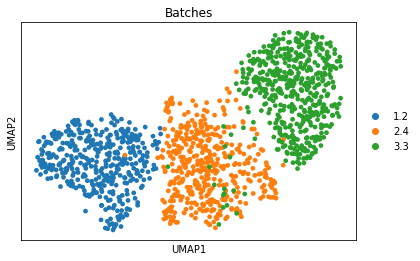

In [133]:
# ######################## Model training

# Major batch effect!

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

params.dec_kl_w = 10
sed_net = SEDR_Train(adata_X, graph_dict, params)
if params.using_dec:
    losses = sed_net.train_with_dec(return_loss=True)
else:
    losses = sed_net.train_without_dec(return_loss=True)
sed_feat, _, _, _ = sed_net.process()

adata_sed = anndata.AnnData(sed_feat)
adata_sed.obsm['spatial'] = adata_h5.obsm['spatial']
adata_sed.obs['batch_label'] = pd.Categorical(adata_h5.obs['batch_label'])
sc.pp.neighbors(adata_sed)
sc.tl.leiden(adata_sed, key_added="SEDR_leiden", resolution=params.eval_resolution)
sc.tl.umap(adata_sed)
sc.pl.umap(adata_sed, color=["batch_label"], title=['Batches'], color_map="tab10", save='batches.png')

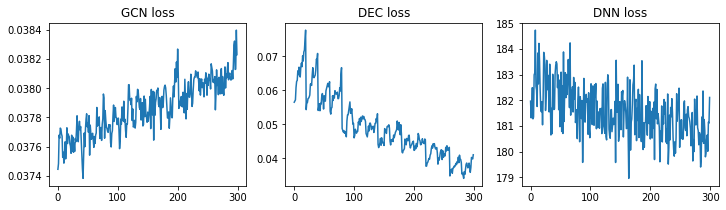

In [134]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3)) 
loss_names = ['GCN loss', 'DEC loss', 'DNN loss']
for i, ax in enumerate(axes.ravel()):
    ax.plot(losses[i])
    ax.set_title(loss_names[i])
plt.show()

GNN model train without DEC:  |################| 300 / 300 | Left time: 0.00 mins| Loss: 181.8639GNN model train without DEC:  |############    | 230 / 300 | Left time: 0.13 mins| Loss: 182.6307GNN model train without DEC:  |############### | 298 / 300 | Left time: 0.01 mins| Loss: 183.5920
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next majo

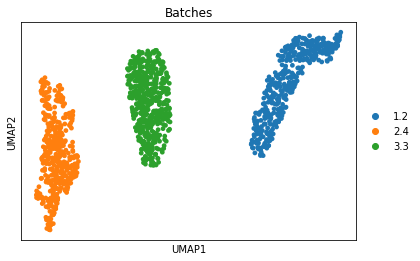

In [136]:
# ######################## Model training

# Even worse!

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

params.dec_kl_w = 50
sed_net = SEDR_Train(adata_X, graph_dict, params)
if params.using_dec:
    losses = sed_net.train_with_dec(return_loss=True)
else:
    losses = sed_net.train_without_dec(return_loss=True)
sed_feat, _, _, _ = sed_net.process()

adata_sed = anndata.AnnData(sed_feat)
adata_sed.obsm['spatial'] = adata_h5.obsm['spatial']
adata_sed.obs['batch_label'] = pd.Categorical(adata_h5.obs['batch_label'])
sc.pp.neighbors(adata_sed)
sc.tl.leiden(adata_sed, key_added="SEDR_leiden", resolution=params.eval_resolution)
sc.tl.umap(adata_sed)
sc.pl.umap(adata_sed, color=["batch_label"], title=['Batches'], color_map="tab10", save='batches1.png')

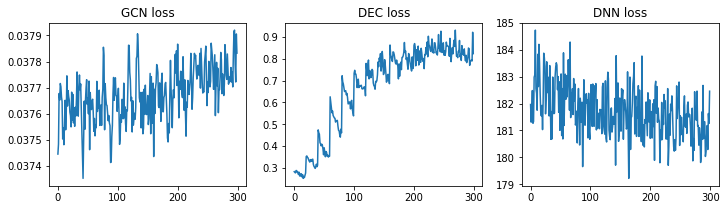

In [137]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3)) 
loss_names = ['GCN loss', 'DEC loss', 'DNN loss']
for i, ax in enumerate(axes.ravel()):
    ax.plot(losses[i])
    ax.set_title(loss_names[i])
plt.show()

GNN model train without DEC:  |################| 300 / 300 | Left time: 0.00 mins| Loss: 181.8639
/home/basia/Documents/magisterka/CBS/project/SEDR/src/SEDR_train.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_kl = F.kl_div(out_q.log(), torch.tensor(tmp_p).to(self.device)).to(self.device)
/home/basia/miniconda3/envs/SEDR_Env/lib/python3.8/site-packages/torch/nn/functional.py:2610: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
Training Graph Net with DEC loss:  |################| 300 / 300 | Loss: 182.1678


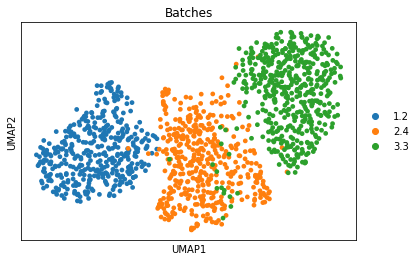

In [139]:
# ######################## Model training

# Very similar to the first clustering

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

params.dec_kl_w = 1
sed_net = SEDR_Train(adata_X, graph_dict, params)
if params.using_dec:
    losses = sed_net.train_with_dec(return_loss=True)
else:
    losses = sed_net.train_without_dec(return_loss=True)
sed_feat, _, _, _ = sed_net.process()

adata_sed = anndata.AnnData(sed_feat)
adata_sed.obsm['spatial'] = adata_h5.obsm['spatial']
adata_sed.obs['batch_label'] = pd.Categorical(adata_h5.obs['batch_label'])
sc.pp.neighbors(adata_sed)
sc.tl.leiden(adata_sed, key_added="SEDR_leiden", resolution=params.eval_resolution)
sc.tl.umap(adata_sed)
sc.pl.umap(adata_sed, color=["batch_label"], title=['Batches'], color_map="tab10", save='batches2.png')

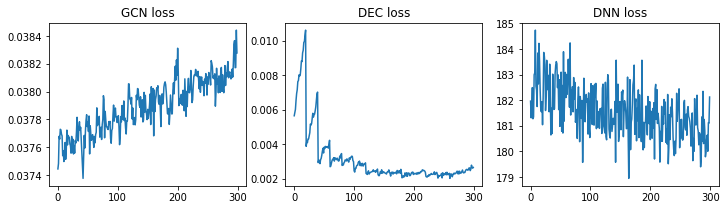

In [140]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3)) 
loss_names = ['GCN loss', 'DEC loss', 'DNN loss']
for i, ax in enumerate(axes.ravel()):
    ax.plot(losses[i])
    ax.set_title(loss_names[i])
plt.show()

# Poisson model results

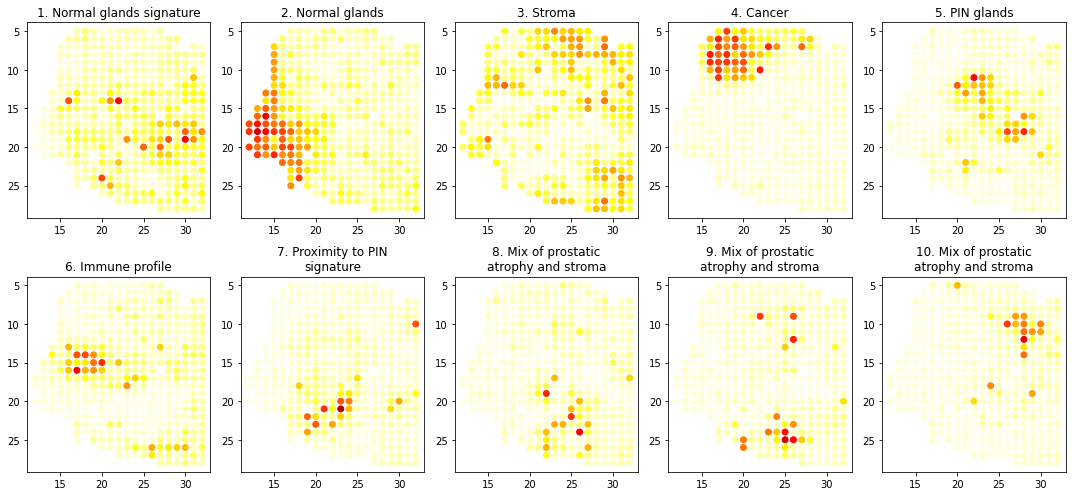

In [51]:
# One section

poisson_preds = pd.read_csv('../Poisson/Supplementary Dataset 1/experiment0000-contributions_spot_type.tsv', sep='\t', index_col=0)
preds_frac = np.array(poisson_preds) / np.array(poisson_preds.sum(axis=1)).reshape(-1, 1)
names = ['Normal glands signature', 'Normal glands', 'Stroma', 'Cancer', 
         'PIN glands', 'Immune profile', 'Proximity to PIN\nsignature',
         'Mix of prostatic\natrophy and stroma', 'Mix of prostatic\natrophy and stroma',
         'Mix of prostatic\natrophy and stroma']

xs = poisson_preds.index.str.split('x').str[0]
xs = xs.astype(int)
ys = poisson_preds.index.str.split('x').str[1]
ys = ys.astype(int)

fig, axes = plt.subplots(2, 5, figsize=(15, 7)) 
for i, ax in enumerate(axes.ravel()):
    if i >= 10:
        ax.remove()
        continue
    ax.scatter(x=xs, y=ys, c=preds_frac[:, i],
              vmin=0, vmax=1, cmap='hot_r')
    ax.set_title(str(i+1) + '. ' + names[i])
    ax.invert_yaxis()
fig.tight_layout()
plt.savefig('../Poisson/factors_10_1.2_v2.png', bbox_inches='tight')

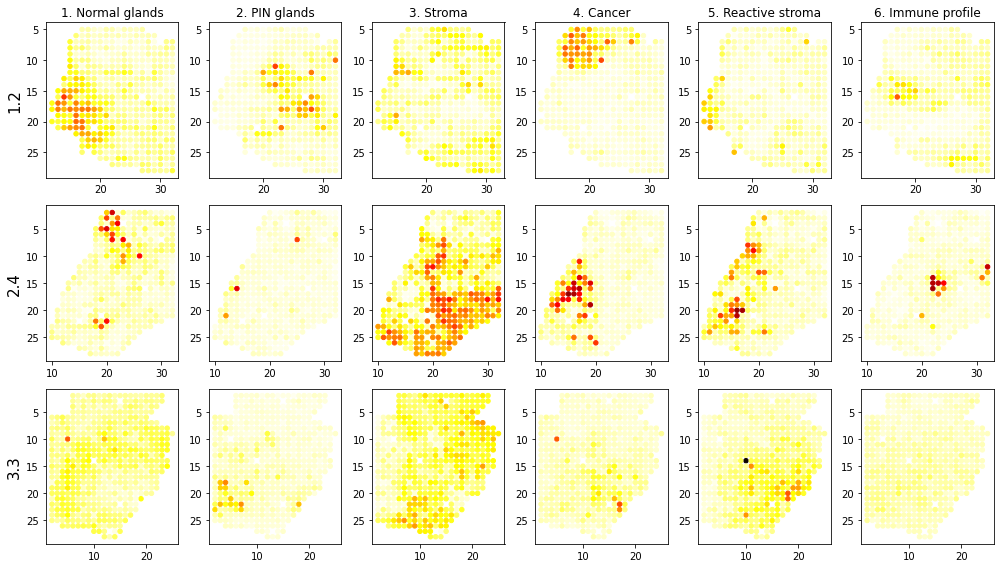

In [101]:
# Three sections

ids = [1, 4, 2, 5, 7, 8]
fig, axes = plt.subplots(3, 6, figsize=(14, 8)) 

sections = ['1.2', '2.4', '3.3']
names = ['Normal glands', 'PIN glands', 'Stroma', 'Cancer', 'Reactive stroma', 'Immune profile']
for k in range(3):   
    poisson_preds = pd.read_csv(f'../Poisson/Supplementary Dataset 2/experiment000{k}-contributions_spot_type.tsv', sep='\t', index_col=0)
    preds_frac = np.array(poisson_preds) / np.array(poisson_preds.sum(axis=1)).reshape(-1, 1)

    xs = poisson_preds.index.str.split('x').str[0]
    xs = xs.astype(int)
    ys = poisson_preds.index.str.split('x').str[1]
    ys = ys.astype(int)

    
    for i in range(6):
        axes[k, i].scatter(x=xs, y=ys, c=preds_frac[:, ids[i]],
                  vmin=0, vmax=1, cmap='hot_r', s=20)
        axes[k, i].invert_yaxis()
        if k == 0:
            axes[k, i].set_title(str(i+1) + '. ' + names[i])
    axes[k, 0].set_ylabel(sections[k], size=15)
fig.tight_layout()
plt.savefig('../Poisson/factors_10_all.png', bbox_inches='tight')

# Seurat results

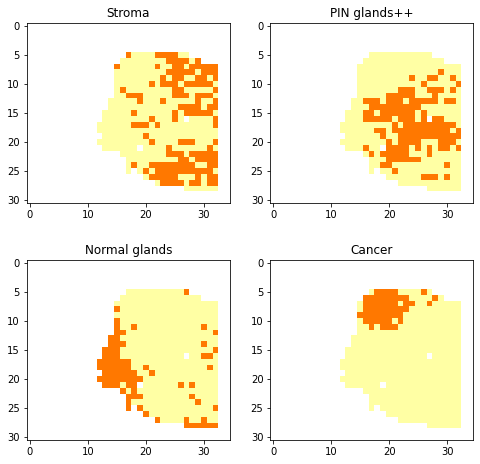

In [108]:
# One section

seurat_clusters = pd.read_csv('../Seurat/seurat_clustering_1.2.csv', index_col=0)
m = to_matrix(seurat_clusters['x'], datas[0].columns)

fig, axes = plt.subplots(2, 2, figsize=(8, 8)) 
names = ['Stroma', 'PIN glands++', 'Normal glands', 'Cancer']
for i, ax in enumerate(axes.ravel()):
    cluster = m.copy()
    cluster[cluster==i] = 1.2
    cluster[(-1 < cluster) & (cluster != 1.2)] = 0
    ax.imshow(cluster, vmin=-0.3, vmax=3, cmap='hot_r')
    ax.set_title(names[i])
plt.savefig('../Seurat/clusters1.2.png', bbox_inches='tight')

Seurat cluster: 0
Poisson factors: ['Stroma', 'Mix of prostatic atrophy and stroma']

Seurat cluster: 1
Poisson factors: ['PIN glands', 'Immune profile', 'Proximity to PIN signature']

Seurat cluster: 2
Poisson factors: ['Normal glands']

Seurat cluster: 3
Poisson factors: ['Cancer']



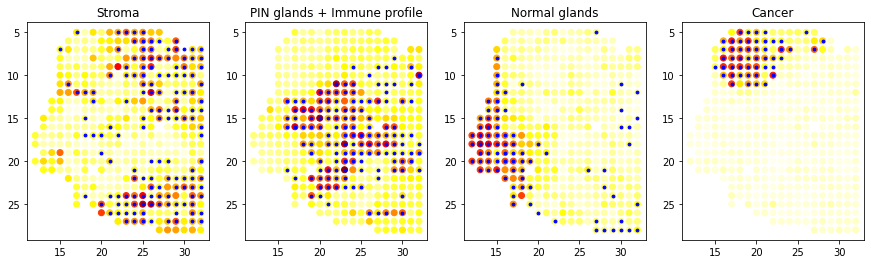

In [109]:
# Poisson results
poisson_preds = pd.read_csv('../Poisson/Supplementary Dataset 1/experiment0000-contributions_spot_type.tsv', sep='\t', index_col=0)
preds_frac = np.array(poisson_preds) / np.array(poisson_preds.sum(axis=1)).reshape(-1, 1)
names_orig = ['Normal glands signature', 'Normal glands', 'Stroma', 'Cancer', 
             'PIN glands', 'Immune profile', 'Proximity to PIN\nsignature',
             'Mix of prostatic\natrophy and stroma', 'Mix of prostatic\natrophy and stroma',
             'Mix of prostatic\natrophy and stroma']

xs = poisson_preds.index.str.split('x').str[0]
xs = xs.astype(int)
ys = poisson_preds.index.str.split('x').str[1]
ys = ys.astype(int)

# Seurat results
seurat_clusters = pd.read_csv('../Seurat/seurat_clustering_1.2.csv', index_col=0)
matches = [[2, 8], [4, 5, 6], [1], [3]]
names = ['Stroma', 'PIN glands + Immune profile', 'Normal glands', 'Cancer']
fig, axes = plt.subplots(1, 4, figsize=(15, 4)) 
for selected_cluster, ax in enumerate(axes.ravel()):
    cluster = seurat_clusters[np.array(seurat_clusters==selected_cluster)]

    coords = cluster.index.str[1:]
    xs_s = coords.str.split('x').str[0]
    xs_s = xs_s.astype(int)
    ys_s = coords.str.split('x').str[1]
    ys_s = ys_s.astype(int)
    
    m = np.array(matches[selected_cluster])
    ax.scatter(x=xs, y=ys, c=preds_frac[:, m].sum(axis=1),
               vmin=0, vmax=1, cmap='hot_r')
    ax.scatter(x=xs_s, y=ys_s, c='b', s=8)
    ax.set_title(selected_cluster)
    ax.invert_yaxis()
    factors = [names_orig[f].replace('\n', ' ') for f in matches[selected_cluster]]
    print(f'Seurat cluster: {selected_cluster}\nPoisson factors: {factors}\n')
    ax.set_title(names[selected_cluster])
plt.savefig('../Seurat/clusters1.2_comparison.png', bbox_inches='tight')

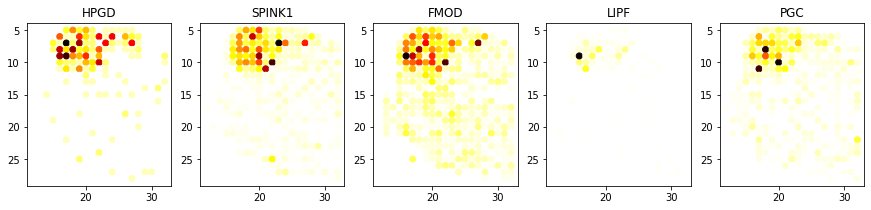

In [113]:
# Marker genes of the cancer cluster, according to Seurat
data_file = '../data/prostate-twelve/P1.2.tsv'
data = pd.read_csv(data_file, sep='\t')
data = data.loc[:, (data>0).sum()>=200]  # spots with at least 200 genes found
data = data[(data>0).sum(axis=1)>=2]  # genes present in at least 2 spots

fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, gene in enumerate(['HPGD', 'SPINK1', 'FMOD', 'LIPF', 'PGC']):
    expr = data.loc[data.index.str.startswith(gene + ' ')].iloc[0]
    xs = data.columns.str.split('x').str[0]
    xs = xs.astype(int)
    ys = data.columns.str.split('x').str[1]
    ys = ys.astype(int)

    axes[i].scatter(x=xs, y=ys, c=expr,
                    cmap='hot_r')
    axes[i].invert_yaxis()
    axes[i].set_title(gene)
plt.savefig('../Seurat/Seurat_cancer_markers.png', bbox_inches='tight')

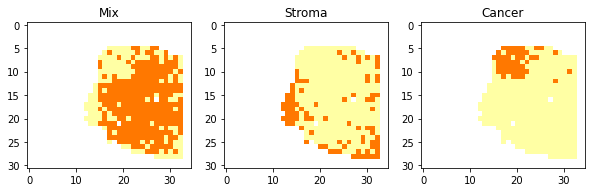

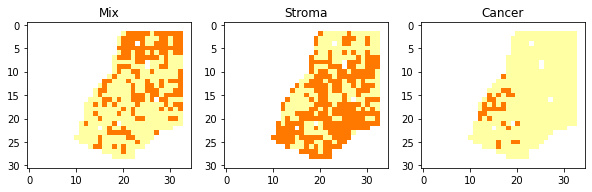

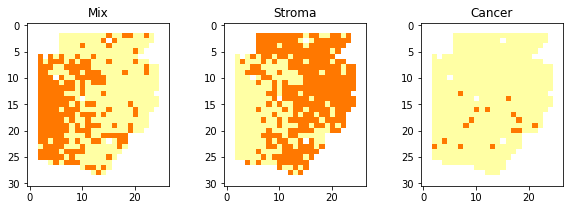

In [121]:
# Three sections

seurat_clusters = pd.read_csv('../Seurat/seurat_clustering1_all_sections.csv', index_col=0)
for k, section in enumerate(sections):
    seurat_clusters_section = seurat_clusters[seurat_clusters.index.str.startswith(section)]
    m = to_matrix(seurat_clusters_section['x'], datas[k].columns)

    fig, axes = plt.subplots(1, 3, figsize=(10, 3)) 
    names = ['Mix', 'Stroma', 'Cancer']
    for i, ax in enumerate(axes.ravel()):
        cluster = m.copy()
        cluster[cluster==i] = 1.2
        cluster[(-1 < cluster) & (cluster != 1.2)] = 0
        ax.imshow(cluster, vmin=-0.3, vmax=3, cmap='hot_r')
        ax.set_title(names[i])

In [127]:
poisson_preds

Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  Factor 6  Factor 7  \
20x25      3053      3127      4842      2861       964      1261      2422   
16x9       6775      2268      3330      1018      1274     19106      1121   
17x20      1511      9101      1831      2221       840       837       946   
22x19      2442      2851      3814      5775      1650      1155     16018   
20x7       5325      1708      2752      2002       464      7855      1140   
...         ...       ...       ...       ...       ...       ...       ...   
25x6       4509       913      4104      1210       939      1461       621   
28x21      2625      2299      1352      3672      1468      1276      2039   
26x5       3991      1104      1679       990       658      2582       587   
29x24      2729      1538      3495      1829       890       674       867   
27x8       3643       983      4033      1553      1092      1264      1049   

       Factor 8  Factor 9  Factor 10  
20x25      1460      2197        945  
16x9       3744       853       1985  
17x20      1442       571        746  
22x19      4882      1174       2035  
20x7       2040       898        924  
...         ...       ...        ...  
25x6       1128       582        984  
28x21      1789       616       1129  
26x5       3740      1598        819  
29x24      1280       719       1037  
27x8       1785      1242       2056  

[405 rows x 10 columns]

Seurat cluster: 0
Poisson factors: ['Normal glands', 'PIN glands', 'Immune profile']

Seurat cluster: 1
Poisson factors: ['Stroma', 'Reactive stroma']

Seurat cluster: 2
Poisson factors: ['Cancer']

Seurat cluster: 0
Poisson factors: ['Normal glands', 'PIN glands', 'Immune profile']

Seurat cluster: 1
Poisson factors: ['Stroma', 'Reactive stroma']

Seurat cluster: 2
Poisson factors: ['Cancer']

Seurat cluster: 0
Poisson factors: ['Normal glands', 'PIN glands', 'Immune profile']

Seurat cluster: 1
Poisson factors: ['Stroma', 'Reactive stroma']

Seurat cluster: 2
Poisson factors: ['Cancer']



/tmp/ipykernel_27910/2991981120.py:14: RuntimeWarning: invalid value encountered in true_divide
  preds_frac = np.array(poisson_preds) / np.array(poisson_preds.sum(axis=1)).reshape(-1, 1)


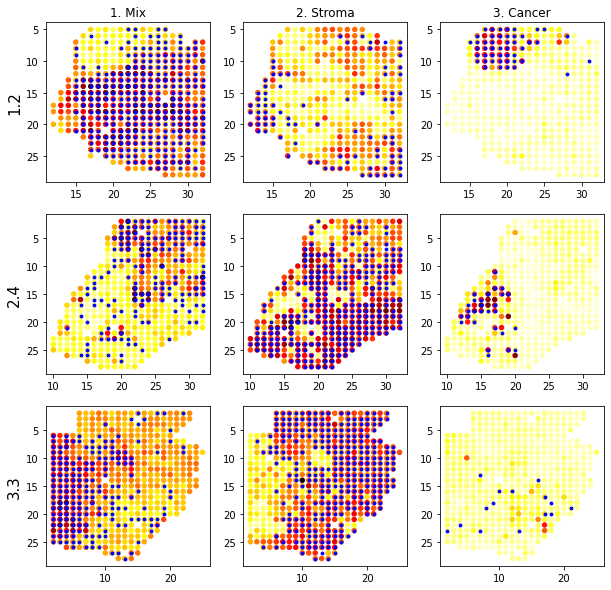

In [130]:
# Three sections

names = ['Mix', 'Stroma', 'Cancer']
names_orig = ['Normal glands', 'PIN glands', 'Stroma', 'Cancer', 'Reactive stroma', 'Immune profile']
matches = [[0, 1, 5], [2, 4], [3]]
ids = [1, 4, 2, 5, 7, 8]

fig, axes = plt.subplots(3, 3, figsize=(10, 10)) 
seurat_clusters = pd.read_csv('../Seurat/seurat_clustering1_all_sections.csv', index_col=0)

for k, section in enumerate(sections):
    poisson_preds = pd.read_csv(f'../Poisson/Supplementary Dataset 2/experiment000{k}-contributions_spot_type.tsv', sep='\t', index_col=0)
    poisson_preds = poisson_preds.iloc[:, ids]
    preds_frac = np.array(poisson_preds) / np.array(poisson_preds.sum(axis=1)).reshape(-1, 1)

    xs = poisson_preds.index.str.split('x').str[0]
    xs = xs.astype(int)
    ys = poisson_preds.index.str.split('x').str[1]
    ys = ys.astype(int)
    
    seurat_clusters_section = seurat_clusters[seurat_clusters.index.str.startswith(section)]
    m = to_matrix(seurat_clusters_section['x'], datas[k].columns)    
    
    for i in range(3):
        cluster = seurat_clusters_section[np.array(seurat_clusters_section==i)]
        coords = cluster.index.str[4:]
        xs_s = coords.str.split('x').str[0]
        xs_s = xs_s.astype(int)
        ys_s = coords.str.split('x').str[1]
        ys_s = ys_s.astype(int)
        m = np.array(matches[i])
        
        axes[k, i].scatter(x=xs, y=ys, c=preds_frac[:, m].sum(axis=1),
                           vmin=0, vmax=1, cmap='hot_r', s=20)
        axes[k, i].scatter(x=xs_s, y=ys_s, c='b', s=8)
        axes[k, i].invert_yaxis()
        factors = [names_orig[f].replace('\n', ' ') for f in matches[i]]
        print(f'Seurat cluster: {i}\nPoisson factors: {factors}\n')
        
        if k == 0:
            axes[k, i].set_title(str(i+1) + '. ' + names[i])
            
    axes[k, 0].set_ylabel(sections[k], size=15)


plt.savefig('../Seurat/clusters_all_comparison.png', bbox_inches='tight')

# THE END